
<h1 align=center><font size = 5> ARIMA MODEL Python Lab</font></h1>
<h1 align=center><font size = 2; color = blue>By Ali Navarro, Economist</font></h1>


In [2]:
import numpy as pd
import pandas as pd
from sklearn import metrics
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings ('ignore')

# Import Dataset

In [66]:
#load of data
file_name = 'sales.csv'
df=pd.read_csv(file_name)
print(df.dtypes)

Fechas     object
Ventas    float64
dtype: object


In [62]:
# we need to order by Fechas Asc to make shore that is the correct order
df.sort_values(by='Fechas', ascending=True, inplace=True) #Inplace=True because we're gonna change the dataset
df

,Ventas
Fechas,
2021-01-02,2468.66
2021-01-09,2693.78
2021-01-16,3127.35
2021-01-23,3653.14
2021-01-30,3521.28
...,...
2023-01-28,17792.19
2023-02-04,19097.26
2023-02-11,19684.52


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fechas  113 non-null    object 
 1   Ventas  113 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [70]:
# overwriting data after changing format
df["Fechas"]= pd.to_datetime(df["Fechas"])

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fechas  113 non-null    datetime64[ns]
 1   Ventas  113 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


Now, the column 'Fechas' is datetime type

In [72]:
df

,Fechas,Ventas
0,2021-01-02,2468.66
1,2021-01-09,2693.78
2,2021-01-16,3127.35
3,2021-01-23,3653.14
4,2021-01-30,3521.28
...,...,...
108,2023-01-28,17792.19
109,2023-02-04,19097.26
110,2023-02-11,19684.52
111,2023-02-18,18628.14


In [73]:
df.set_index("Fechas", inplace = True) #Inplace=True because we're gonna change the dataset
df.head()

,Ventas
Fechas,
2021-01-02,2468.66
2021-01-09,2693.78
2021-01-16,3127.35
2021-01-23,3653.14
2021-01-30,3521.28


In [74]:
# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

### Vizualization


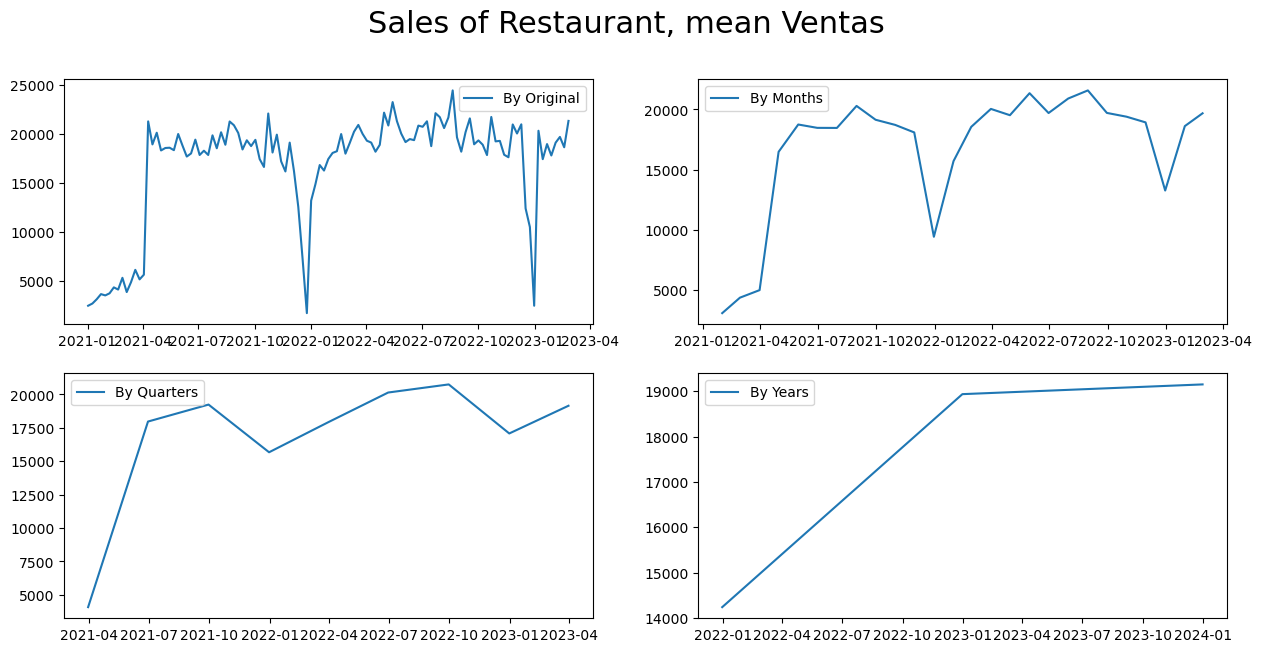

In [79]:
import seaborn as sns

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Sales of Restaurant, mean Ventas', fontsize=22)

plt.subplot(221)
plt.plot(df.Ventas, '-', label='By Original')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Ventas, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Ventas, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Ventas, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.004412


<Figure size 1500x700 with 0 Axes>

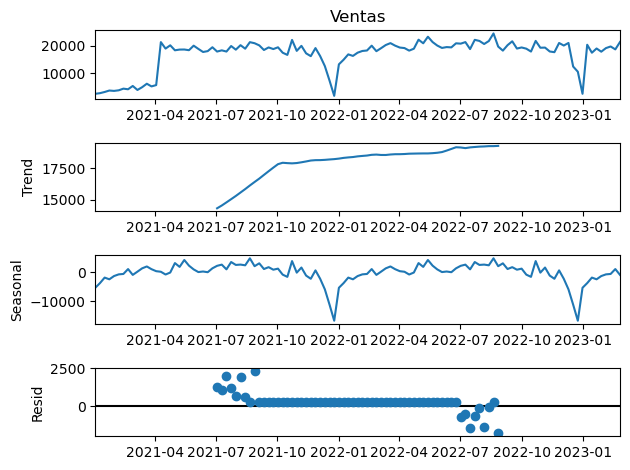

In [121]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df.Ventas).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.Ventas)[1])
plt.show()

We can say that de Serie is <font size = 4>  stacionary </font></h1>  by the dickey-fuller test wich p-value is less than the significance level (say 0.05) then we have to reject the null hypothesis which assumes the presence of a unit root. We do not have to transform the time serie.

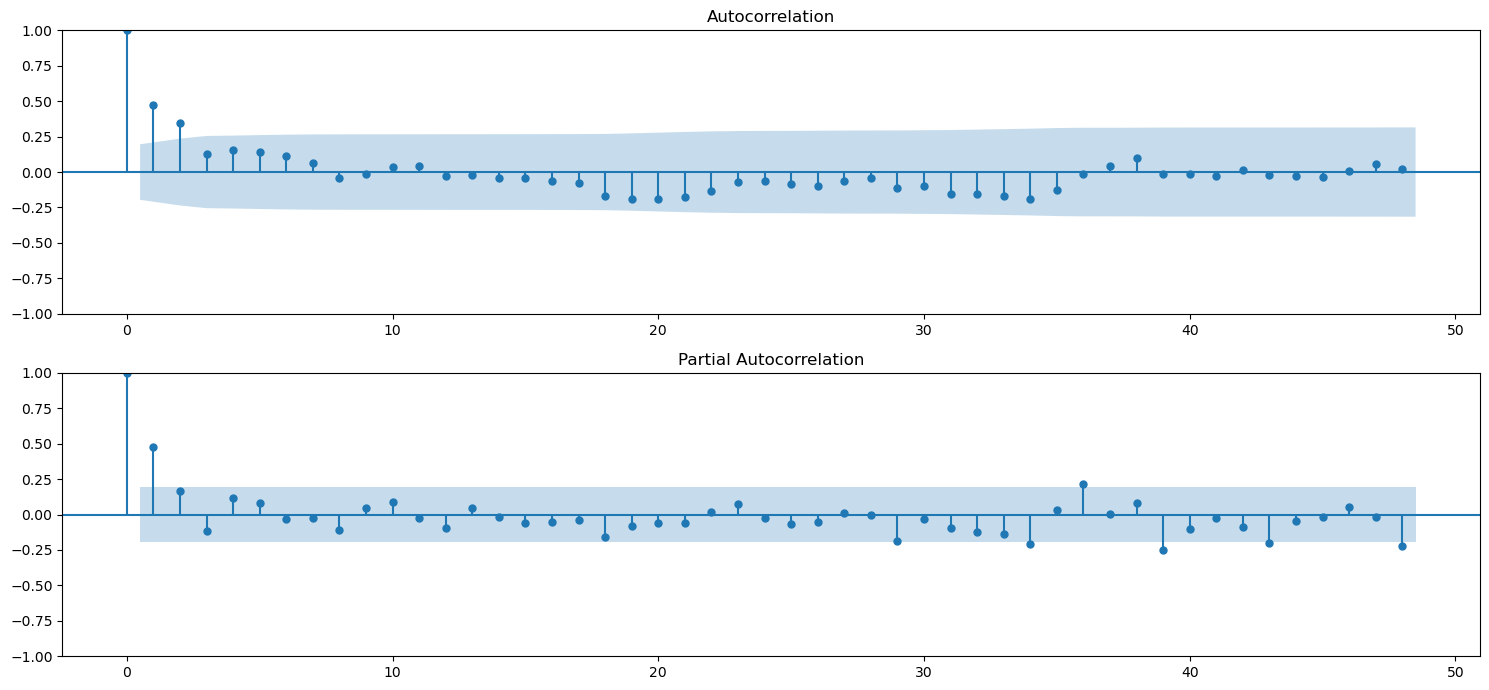

In [120]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Ventas[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Ventas[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

# Model Selection

In [124]:
from itertools import product

# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection loop 
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.Ventas, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [125]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
7   (0, 1, 0, 1)  1924.350522
19  (1, 0, 0, 1)  1924.688755
21  (1, 0, 1, 1)  1924.831222
25  (1, 1, 0, 1)  1924.853107
27  (1, 1, 1, 1)  1925.566671
                                     SARIMAX Results                                      
Dep. Variable:                             Ventas   No. Observations:                  113
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -959.175
Date:                            Tue, 25 Apr 2023   AIC                           1924.351
Time:                                    12:57:44   BIC                           1932.166
Sample:                                01-02-2021   HQIC                          1927.514
                                     - 02-25-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

Dickey–Fuller test:: p=0.000000


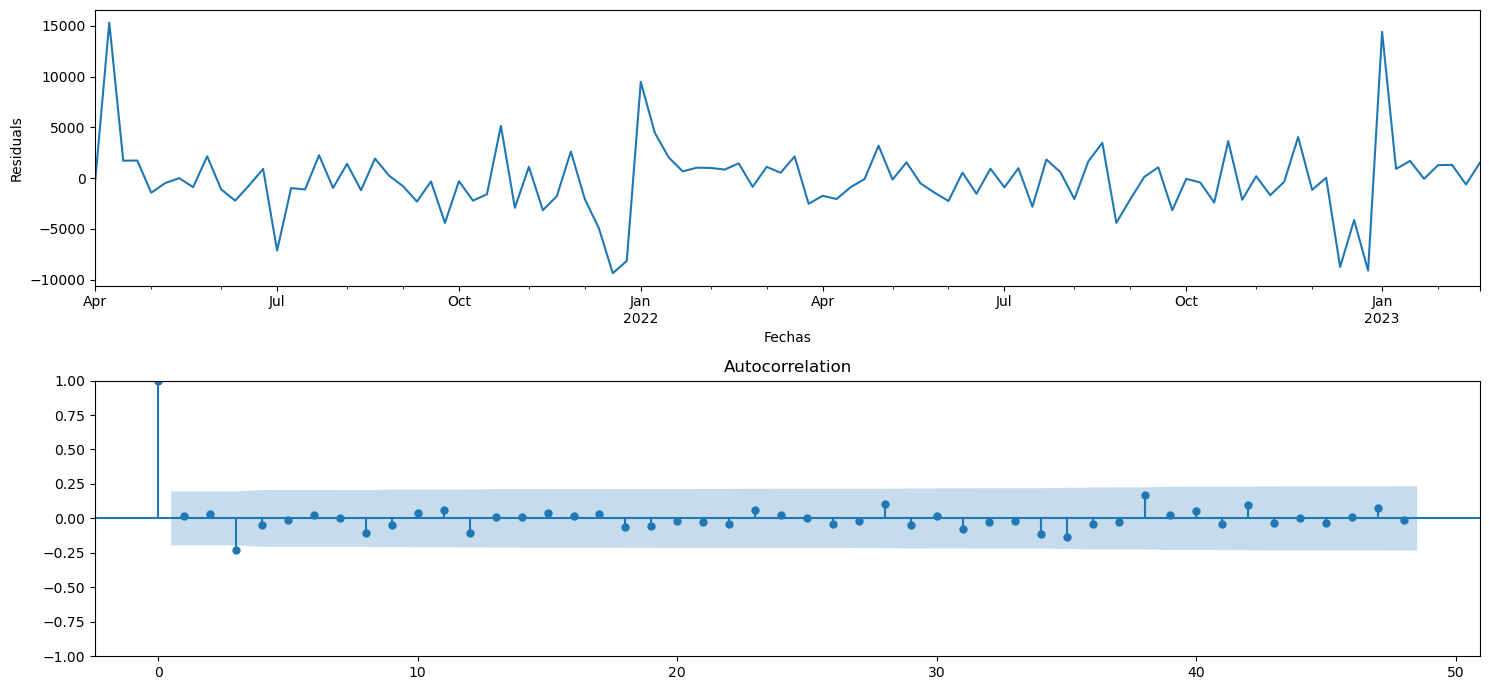

In [126]:
# STL-decomposition (Residual Analysis)
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

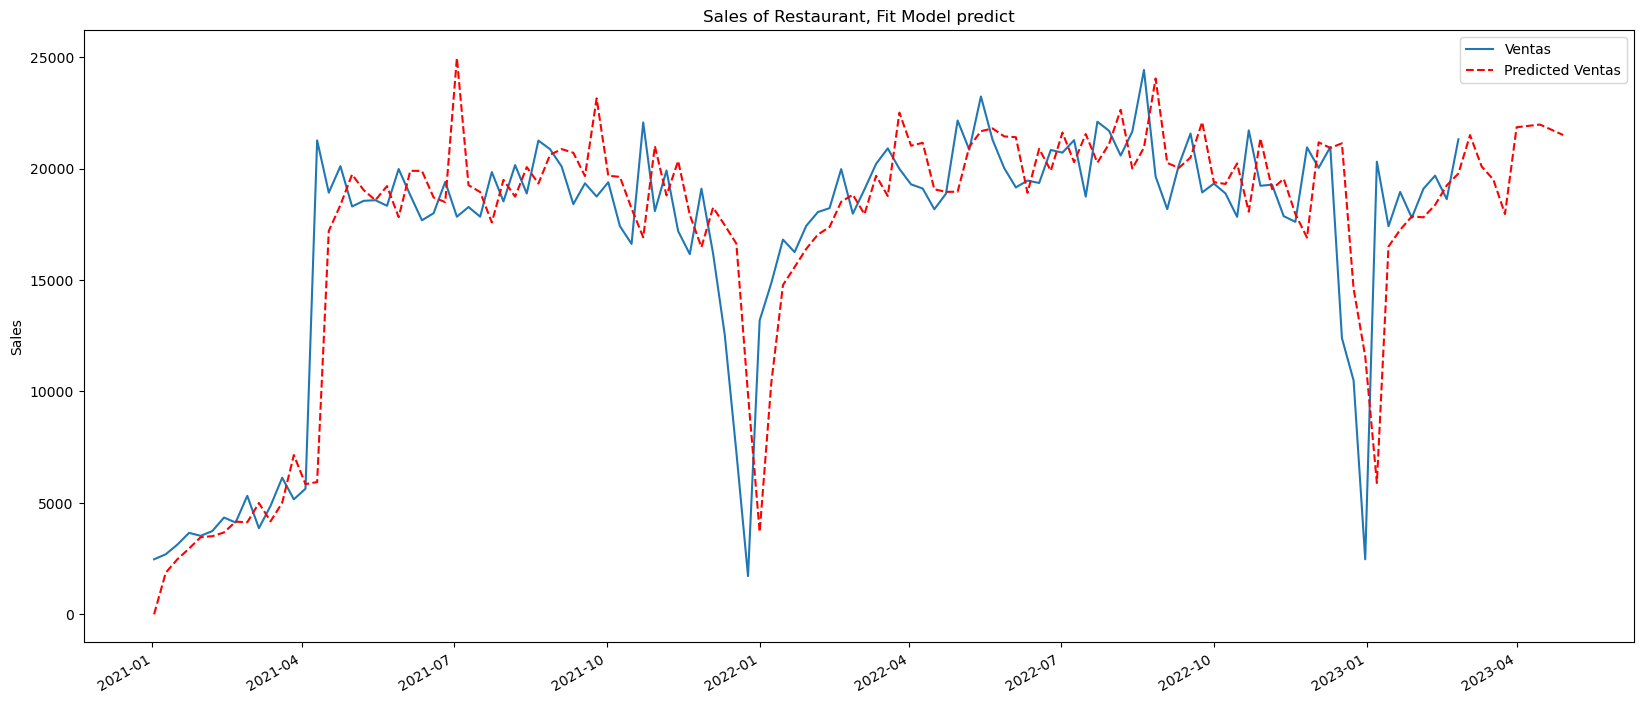

In [182]:
from datetime import datetime

# Prediction
df_predict = df[['Ventas']]
date_list = [datetime(2023, 2, 25), datetime(2023, 3, 4), datetime(2023, 3, 11), datetime(2023, 3, 18), 
             datetime(2023, 3, 25), datetime(2023, 4, 1), datetime(2023, 4, 15), datetime(2024, 4, 22),
             datetime(2023, 4, 29), datetime(2024, 5, 6), datetime(2024, 5, 13),  datetime(2024, 5, 20)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df_predict = pd.concat([df_predict, future])
df_predict['forecast'] = best_model.predict(start=0, end=158)
plt.figure(figsize=(20,9))
df_predict.Ventas.plot()
df_predict.forecast.plot(color='r', ls='--', label='Predicted Ventas')
plt.legend()
plt.title('Sales of Restaurant, Fit Model predict')
plt.ylabel('Sales')
plt.show()

In [188]:
#tabular predicted data
df_predict['forecast'].tail(10)

2023-03-11    20094.620095
2023-03-18    19509.650875
2023-03-25    17962.195946
2023-04-01    21857.281766
2023-04-15    21978.588962
2024-04-22             NaN
2023-04-29    21507.529619
2024-05-06             NaN
2024-05-13             NaN
2024-05-20             NaN
Name: forecast, dtype: float64